In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
# 数据加载
df = pd.read_csv('./bitcoin_2012-01-01_to_2018-10-31.csv')

In [3]:
# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp

In [4]:
# 数据探索
print(df.head())

            Timestamp      Open      High       Low     Close  Volume_(BTC)  \
Timestamp                                                                     
2011-12-31 2011-12-31  4.465000  4.482500  4.465000  4.482500     23.829470   
2012-01-01 2012-01-01  4.806667  4.806667  4.806667  4.806667      7.200667   
2012-01-02 2012-01-02  5.000000  5.000000  5.000000  5.000000     19.048000   
2012-01-03 2012-01-03  5.252500  5.252500  5.252500  5.252500     11.004660   
2012-01-04 2012-01-04  5.200000  5.223333  5.200000  5.223333     11.914807   

            Volume_(Currency)  Weighted_Price  
Timestamp                                      
2011-12-31         106.330084        4.471603  
2012-01-01          35.259720        4.806667  
2012-01-02          95.240000        5.000000  
2012-01-03          58.100651        5.252500  
2012-01-04          63.119578        5.208159  


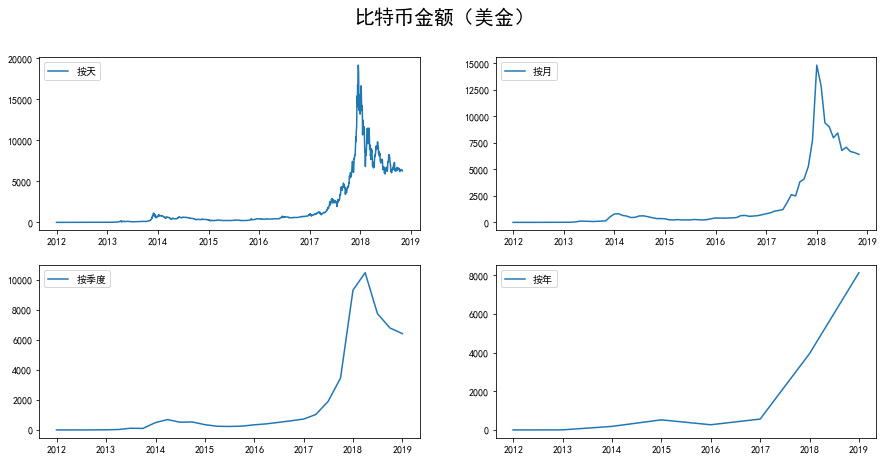

In [5]:
# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
# 按照天，月，季度，年来显示比特币的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('比特币金额（美金）', fontsize=20)
plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='按年')
plt.legend()
plt.show()

In [18]:
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)

In [14]:
for i in parameters:
    print(i)

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


In [19]:
parameters_list = list(parameters) 
parameters_list

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [20]:
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Weighted_Price,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

参数错误: (0, 2)


In [21]:
results

[[(0, 0), 1574.9414390103977],
 [(0, 1), 1485.9999331170677],
 [(1, 0), 1388.133936432175],
 [(1, 1), 1385.5223153854836],
 [(1, 2), 1387.2197682070837],
 [(2, 0), 1386.5054795611345],
 [(2, 1), 1387.3190784039018],
 [(2, 2), 1389.1342871162126]]

In [22]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         Weighted_Price   No. Observations:                   83
Model:                     ARMA(1, 1)   Log Likelihood                -688.761
Method:                       css-mle   S.D. of innovations            957.764
Date:                Thu, 16 Sep 2021   AIC                           1385.522
Time:                        16:42:18   BIC                           1395.198
Sample:                    12-31-2011   HQIC                          1389.409
                         - 10-31-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2106.5174   1567.776      1.344      0.179    -966.267    5179.301
ar.L1.Weighted_Price     0.9251      0.042     22.040      0.000       0.843       1.007
ma.L1.Weighted_Price     0.2681      0.116      2.311      0.021       0.041       0.495
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0809           +0.0000j            1.0809            0.0000
MA.1           -3.7303           +0.0000j            3.7303            0.5000
-----------------------------------------------------------------------------
"""

In [23]:
# 比特币预测
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2018, 11, 30), datetime(2018, 12, 31), datetime(2019, 1, 31), datetime(2019, 2, 28), datetime(2019, 3, 31), 
             datetime(2019, 4, 30), datetime(2019, 5, 31), datetime(2019, 6, 30)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=91)

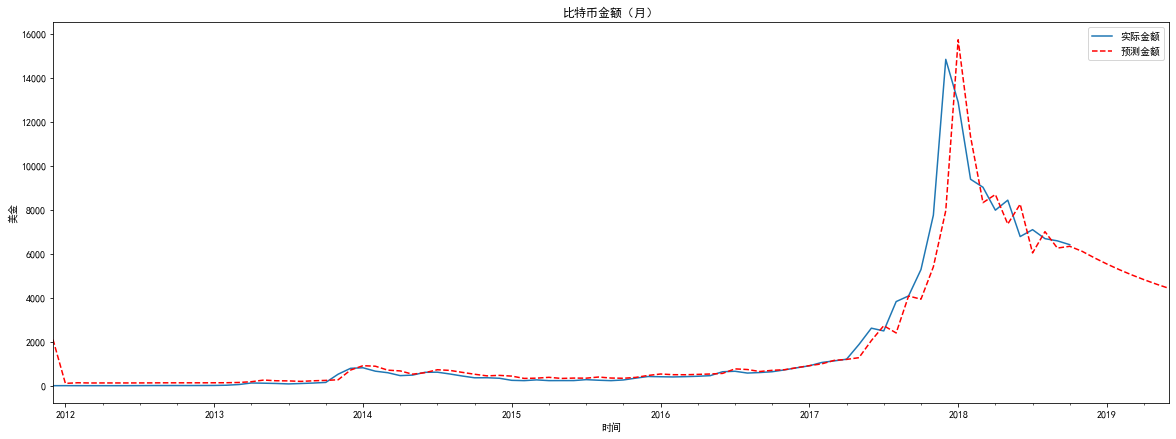

In [24]:
# 比特币预测结果显示
plt.figure(figsize=(20,7))
df_month2.Weighted_Price.plot(label='实际金额')
df_month2.forecast.plot(color='r', ls='--', label='预测金额')
plt.legend()
plt.title('比特币金额（月）')
plt.xlabel('时间')
plt.ylabel('美金')
plt.show()